In [1]:
%matplotlib inline
import numpy as np
import torch
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorboardX, datetime
import pandas as pd
from scipy.special import gamma
from torch import nn
from scipy.stats import special_ortho_group
from collections import defaultdict
from collections import OrderedDict as odict
from copy import deepcopy

## Theory

Consider the $d$-dimensional space $\mathbb{R}^{d}$, and the following charge:

$$\rho(x) = \delta^d(x).$$

For $d \neq 2$, the analytical solution to the system

$$\nabla \cdot \vec{E} = \rho$$

$$\nabla V = \vec{E}$$

can be defined as 

$$V_{\vec{x}} = \frac{\Gamma(d/2)}{2\cdot\pi^{d/2}\cdot (2-d)} \|\vec{x}\|^{2-d}, $$

$$\vec{E}_{\vec{x}} = \frac{\Gamma(d/2)}{2\cdot \pi^{d/2}\cdot \|\vec{x}\|^{d}} \vec{x}.$$

For $d=2$, $\vec{E}_{\vec{x}}$ is the same, but for $V_{\vec{x}}$ we have

$$V_{\vec{x}} = \frac{1}{2\pi} \ln(\|\vec{x}\|).$$

We want to solve this system using the divergence theorem:

$$\iint_{S_{d-1}(V)} \vec{E}\cdot \hat{n}\text{ d}S = \iiint_{V_d} \nabla.\vec{E}\text{ d}V.$$

Keep in mind that the $d-1$-dimensional surface of a $d$-dimensional shpere with radius $r$ is 
$$\iint_{S_{d-1}(V^{\text{d-Ball}}_{r})} 1\text{ d}S = \frac{2\cdot \pi^{d/2}}{\Gamma(d/2)}\cdot r^{d-1}.$$

In [2]:
device_name = 'cuda:0'
tch_device = torch.device(device_name)
tch_dtype = torch.double
torch.pi = torch.tensor(np.pi).to(device=tch_device, dtype=tch_dtype)

def isscalar(v):
    if torch.is_tensor(v):
        return v.numel() == 1
    else:
        return np.isscalar(v)

## Defining the Problem and the Analytical Solution

In [3]:
class DeltaProblem:
    def __init__(self, weights, locations):
        # weights          -> np.array -> shape=(N,)
        # locations.shape  -> np.array -> shape=(N,d)
        self.weights = weights
        self.locations = locations
        self.n = self.weights.size
        self.d = self.locations.shape[1]
        assert self.weights.shape   == (self.n,)
        assert self.locations.shape == (self.n, self.d)
        self.weights_tch = torch.from_numpy(self.weights).to(tch_device, tch_dtype)
        self.locations_tch = torch.from_numpy(self.locations).to(tch_device, tch_dtype)
    
    def integrate_volumes(self, volumes):
        # volumes -> dictionary
        assert volumes['type'] == 'balls'
        centers = volumes['centers']
        radii = volumes['radii']
        N_v = centers.shape[0]
        N_mu, d = self.n, self.d
        assert radii.shape == (N_v,)
        lib = torch if torch.is_tensor(centers) else np 
        mu = self.locations_tch if torch.is_tensor(centers) else self.locations
        w = self.weights_tch if torch.is_tensor(centers) else self.weights
        
        c_diff_mu = centers.reshape(N_v, 1, d) - mu.reshape(1, N_mu, d)
        assert c_diff_mu.shape == (N_v, N_mu, d)
        distl2 = lib.sqrt(lib.square(c_diff_mu).sum(-1))
        assert distl2.shape == (N_v, N_mu)
        integ = ((distl2 < radii.reshape(N_v, 1)) * w.reshape(1, N_mu)).sum(-1)
        assert integ.shape == (N_v,)
        return integ
    
    def potential(self, x):
        lib = torch if torch.is_tensor(x) else np 
        w = self.weights_tch if torch.is_tensor(x) else self.weights
        mu = self.locations_tch if torch.is_tensor(x) else self.locations
        N_mu, d = self.n, self.d
        N_x = x.shape[0]
        assert x.shape == (N_x, d)
        x_diff_mu = x.reshape(N_x, 1, d) - mu.reshape(1, N_mu, d)
        assert x_diff_mu.shape == (N_x, N_mu, d)
        x_dists = lib.sqrt(lib.square(x_diff_mu).sum(-1))
        assert x_dists.shape == (N_x, N_mu)
        if d != 2:
            poten1 = (x_dists**(2-d))
            assert poten1.shape == (N_x, N_mu)
            poten2 = (poten1 * w.reshape(1, N_mu)).sum(-1)
            assert poten2.shape == (N_x,)
            cst = gamma(d/2) / (2*(lib.pi**(d/2)))
            cst = cst / (2-d)
            assert isscalar(cst)
            poten = cst * poten2
            assert poten.shape == (N_x,)
        else:
            poten1 = lib.log(x_dists)
            assert poten1.shape == (N_x, N_mu)
            poten2 = (poten1 * w.reshape(1, N_mu)).sum(-1)
            assert poten2.shape == (N_x,)
            poten = poten2 / (2*lib.pi)
            assert poten.shape == (N_x,)
        return poten
    
    def field(self, x):
        lib = torch if torch.is_tensor(x) else np 
        w = self.weights_tch if torch.is_tensor(x) else self.weights
        mu = self.locations_tch if torch.is_tensor(x) else self.locations
        N_mu, d = self.n, self.d
        N_x = x.shape[0]
        assert x.shape == (N_x, d)
        x_diff_mu = x.reshape(N_x, 1, d) - mu.reshape(1, N_mu, d)
        assert x_diff_mu.shape == (N_x, N_mu, d)
        x_dists = lib.sqrt(lib.square(x_diff_mu).sum(-1))
        assert x_dists.shape == (N_x, N_mu)
        poten1 = (x_dists**(-d))
        assert poten1.shape == (N_x, N_mu)
        poten2 = (poten1 * w.reshape(1, N_mu)).sum(-1)
        assert poten2.shape == (N_x,)
        cst = gamma(d/2) / (2*(lib.pi**(d/2)))
        assert isscalar(cst)
        poten = cst * poten2
        assert poten.shape == (N_x,)
        field = poten.reshape(N_x, 1) * x
        assert field.shape == (N_x, d)
        return field

## Visualizing the True Potential and Fields

In [4]:
x1_1d = torch.linspace(-1.0, 1.0, 50, requires_grad=True, dtype=tch_dtype, device=tch_device)
x2_1d = torch.linspace(-1.0, 1.0, 50, requires_grad=True, dtype=tch_dtype, device=tch_device)
x1_msh, x2_msh = torch.meshgrid(x1_1d, x2_1d)
x1 = x1_msh.reshape(-1, 1)
x2 = x2_msh.reshape(-1, 1)
x1_1d_c = x1_1d.reshape(-1, 1)
x2_1d_c = x2_1d.reshape(-1, 1)
x1_msh_np = x1_msh.detach().cpu().numpy()
x2_msh_np = x2_msh.detach().cpu().numpy()
x = torch.cat([x1, x2], dim=1)
x_np = x.detach().cpu().numpy()
x_plt, x_plt_np = x, x_np
x1_plt_msh_np, x2_plt_msh_np = x1_msh_np, x2_msh_np

In [5]:
def do_plot(x1_msh_np, x2_msh_np, v_msh_np, e_msh_np=None, e_percentile_cap=None, 
            dpi=72, fig_ax=None):
    plt.ioff()
    if fig_ax is None:
        fig = plt.figure(dpi=dpi)
        ax = plt.gca()
    else:
        fig, ax = fig_ax
    im = ax.pcolormesh(x1_msh_np, x2_msh_np, v_msh_np, shading='auto', cmap='RdBu')
    fig.colorbar(im, ax=ax)
    if e_msh_np is not None:
        if e_percentile_cap is not None:
            e_size = np.sqrt((e_msh_np**2).sum(axis=-1))
            e_size_cap = np.percentile(a=e_size, q=e_percentile_cap, axis=None)
            cap_coef = np.ones_like(e_size)
            cap_coef[e_size > e_size_cap] = e_size_cap / e_size[e_size > e_size_cap]
            e_msh_capped = e_msh_np * cap_coef.reshape(*e_msh_np.shape[:-1], 1)
        else:
            e_msh_capped = e_msh_np
        
        ax.quiver(x1_msh_np, x2_msh_np, e_msh_capped[:, :, 0], e_msh_capped[:, :, 1])
    return fig, ax

In [6]:
prob2d_ex1 = DeltaProblem(weights=np.array([1.0]),
                         locations=np.array([[ 0.0,  0.0]]))

prob2d_ex1 = DeltaProblem(weights=np.array([1.0, 1.0, 1.0]),
                         locations=np.array([[ 0.0,  0.0],
                                             [-0.5, -0.5],
                                             [ 0.5,  0.5]]))

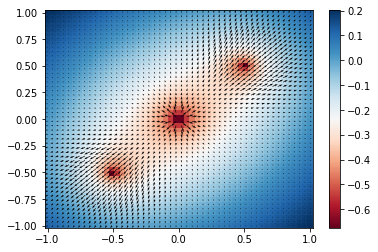

In [7]:
v_ex = prob2d_ex1.potential(x_plt_np)
e_ex = prob2d_ex1.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_ex.reshape(*x1_plt_msh_np.shape),
                  e_ex.reshape(*x1_plt_msh_np.shape, 2),
                  e_percentile_cap=90, dpi=72)

fig

### Defining the Volume Sampler

In [8]:
class BallSampler:
    def __init__(self, x_min, x_max, r_min, r_max):
        self.np_random = None
        self.tch_random = None
        self.d = x_min.size
        self.x_min = x_min.reshape(1, self.d)
        self.x_max = x_max.reshape(1, self.d)
        self.r_min = r_min
        self.r_max = r_max
        self.x_size = (self.x_max - self.x_min)
        self.r_size = (self.r_max - self.r_min)
        
        self.x_min_tch = torch.from_numpy(self.x_min).to(device=tch_device, dtype=tch_dtype)
        self.x_max_tch = torch.from_numpy(self.x_max).to(device=tch_device, dtype=tch_dtype)
        self.r_min_tch = torch.tensor(self.r_min).to(device=tch_device, dtype=tch_dtype)
        self.r_max_tch = torch.tensor(self.r_max).to(device=tch_device, dtype=tch_dtype)
        self.x_size_tch = torch.from_numpy(self.x_size).to(device=tch_device, dtype=tch_dtype)
        self.r_size_tch = torch.tensor(self.r_size).to(device=tch_device, dtype=tch_dtype)
    
    def seed(self, seed=None):
        self.tch_random = torch.Generator(device=tch_device)
        self.np_random = np.random.RandomState(seed=seed)
        tch_seed = self.np_random.randint(0, 0x0fff_ffff_ffff_ffff)
        self.tch_random.manual_seed(tch_seed)
        return seed
    
    def __call__(self, n=1, lib='numpy'):
        if lib == 'numpy':
            radii = self.np_random.uniform(self.r_min, self.r_max, size=(n,))
            centers = self.np_random.uniform(0.0, 1.0, size=(n, self.d))
            centers = centers * self.x_size + self.x_min
        elif lib == 'torch':
            radii = torch.empty(n, device=tch_device, dtype=tch_dtype)
            radii = radii.uniform_(generator=self.tch_random) * self.r_size_tch + self.r_min_tch
            centers = torch.empty(n, self.d, device=tch_device, dtype=tch_dtype)
            centers = centers.uniform_(generator=self.tch_random) * self.x_size_tch + self.x_min_tch
        else:
            raise RuntimeError('Not implemented!')
        d = dict()
        d['type'] = 'balls'
        d['centers'] = centers
        d['radii'] = radii
        return d

### Visualizing the Sampler and Integrator

In [9]:
prob2d_ex2 = DeltaProblem(weights=np.array([1.0, 1.0, 1.0]),
                          locations=np.array([[ 0.0,  0.0],
                                              [-0.5, -0.5],
                                              [ 0.5,  0.5]]))

volsampler_2d = BallSampler(x_min=np.array([-1.0, -1.0]), x_max=np.array([1.0, 1.0]), r_min=0.1, r_max=1.5)
volsampler_2d.seed(12345)

vols = volsampler_2d(n=10, lib='torch')
integs = prob2d_ex2.integrate_volumes(vols)
for key, val in vols.items():
    if torch.is_tensor(val):
        vols[key] = val.detach().cpu().numpy()

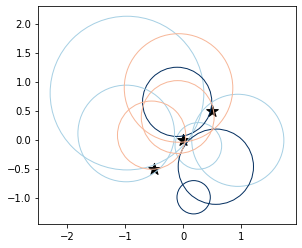

In [10]:
fig = plt.figure(dpi=72)
ax = plt.gca()

max_integ = prob2d_ex2.weights[prob2d_ex2.weights > 0].sum()
min_integ = prob2d_ex2.weights[prob2d_ex2.weights < 0].sum()
cmap = mpl.cm.get_cmap('RdBu')
cnorm = mpl.colors.Normalize(vmin=min_integ, vmax=max_integ)

ax.scatter(prob2d_ex2.locations[:,0], prob2d_ex2.locations[:,1], marker='*', color='black', s=150)
for center, radius, integ in zip(vols['centers'], vols['radii'], integs):
    circle = plt.Circle(center, radius, fill=False, 
                        color=cmap(1.0-cnorm(integ.item())))
    ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')
fig

### Sphere Sampling

In [11]:
class SphereSampler:
    def __init__(self):
        self.np_random = None
        self.tch_random = None
    
    def seed(self, seed=None):
        self.tch_random = torch.Generator(device=tch_device)
        self.np_random = np.random.RandomState(seed=seed)
        tch_seed = self.np_random.randint(0, 0x0fff_ffff_ffff_ffff)
        self.tch_random.manual_seed(tch_seed)
        return seed
    
    def np_exlinspace(self, start, end, n):
        assert n >= 1
        a = np.linspace(start, end, n, endpoint=False) 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def tch_exlinspace(self, start, end, n):
        assert n >= 1
        a = torch.linspace(start, end, n+1, device=tch_device, dtype=tch_dtype)[:-1] 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def __call__(self, volumes, n, do_detspacing=True):
        # volumes -> dictionary
        assert volumes['type'] == 'balls'
        centers = volumes['centers']
        radii = volumes['radii']
        N_v, d = centers.shape
        assert centers.shape == (N_v, d)
        assert radii.shape == (N_v,)
        use_np = not torch.is_tensor(centers)
        exlinspace = self.np_exlinspace if use_np else self.tch_exlinspace
        meshgrid = np.meshgrid if use_np else torch.meshgrid
        sin = np.sin if use_np else torch.sin
        cos = np.cos if use_np else torch.cos
        matmul = np.matmul if use_np else torch.matmul
        
        if do_detspacing and (d == 2):
            theta = exlinspace(0.0, 2*np.pi, n)
            assert theta.shape == (n,)
            theta_2d = theta.reshape(n, 1)
            x_tilde_2d_list = [cos(theta_2d), sin(theta_2d)]
            if use_np:
                x_tilde_2d = np.concatenate(x_tilde_2d_list, axis=1)
            else:
                x_tilde_2d = torch.cat(x_tilde_2d_list, dim=1)
            assert x_tilde_2d.shape == (n ,d)
            x_tilde = x_tilde_2d.reshape(1, n, d)
            assert x_tilde.shape == (1, n ,d)
        elif do_detspacing and (d == 3):
            n_sqrt = int(np.sqrt(n))
            assert n == n_sqrt * n_sqrt, 'Need n to be int-square for now!'
            theta_1d = exlinspace(0.0, 2*np.pi, n_sqrt)
            unit_unif = exlinspace(0.0, 1.0, n_sqrt)
            if use_np:
                phi_1d = np.arccos(1-2*unit_unif)
            else:
                phi_1d = torch.arccos(1-2*unit_unif)
            theta_msh, phi_msh = meshgrid(theta_1d, phi_1d)
            assert theta_msh.shape == (n_sqrt, n_sqrt)
            assert phi_msh.shape == (n_sqrt, n_sqrt)
            theta_2d, phi_2d = theta_msh.reshape(n, 1), phi_msh.reshape(n, 1)
            assert theta_2d.shape == (n, 1)
            assert phi_2d.shape == (n, 1)
            x_tilde_lst = [sin(phi_2d) * cos(theta), sin(phi_2d) * sin(theta), cos(phi_2d)]
            if use_np:
                x_tilde_2d = np.concatenate(x_tilde_lst, axis=1)
            else:
                x_tilde_2d = torch.cat(x_tilde_lst, dim=1)
            assert x_tilde_2d.shape == (n ,d)
            x_tilde = x_tilde_2d.reshape(1, n, d)
            assert x_tilde.shape == (1, n ,d)
        elif (not do_detspacing) and use_np:
            x_tilde_unnorm = self.np_random.randn(N_v, n, d)
            x_tilde_l2 = np.sqrt(torch.square(x_tilde_unnorm).sum(axis=-1))
            x_tilde = x_tilde_unnorm / x_tilde_l2.reshape(N_v, n, 1)
            assert x_tilde.shape == (N_v, n ,d)
        elif (not do_detspacing) and (not use_np):
            x_tilde_unnorm = torch.empty(N_v, n, d, device=tch_device, dtype=tch_dtype)
            x_tilde_unnorm = x_tilde_unnorm.normal_(generator=self.tch_random)
            x_tilde_l2 = torch.sqrt(torch.square(x_tilde_unnorm).sum(dim=-1))
            x_tilde = x_tilde_unnorm / x_tilde_l2.reshape(N_v, n, 1)
            assert x_tilde.shape == (N_v, n ,d)
        else:
            raise RuntimeError('Not implemented yet!')
            
        rot_mats_np = special_ortho_group.rvs(dim=d, size=N_v, random_state=self.np_random)
        if use_np:
            rot_mats = rot_mats_np
        else:
            rot_mats = torch.from_numpy(rot_mats_np).to(device=tch_device, dtype=tch_dtype)
        assert rot_mats.shape == (N_v, d, d)
        
        x_tilde_rot = matmul(x_tilde, rot_mats)
        assert x_tilde_rot.shape == (N_v, n, d)
        
        points = x_tilde_rot * radii.reshape(N_v, 1, 1) + centers.reshape(N_v, 1, d)
        assert points.shape == (N_v, n, d)
        
        if use_np:
            x_tilde_bc = np.broadcast_to(x_tilde, (N_v, n, d))
        else:
            x_tilde_bc = x_tilde.expand(N_v, n, d)
        rot_x_tilde = matmul(x_tilde_bc, rot_mats)
        assert rot_x_tilde.shape == (N_v, n, d)
        
        cst = (2*(np.pi**(d/2))) / gamma(d/2)
        csts = cst * (radii**(d-1))
        assert csts.shape == (N_v,)
        
        ret_dict = dict(points=points, normals=rot_x_tilde, areas=csts)
        return ret_dict

In [12]:
prob2d_ex3 = DeltaProblem(weights=np.array([1.0, 1.0, 1.0]),
                          locations=np.array([[ 0.0,  0.0],
                                              [-0.5, -0.5],
                                              [ 0.5,  0.5]]))

volsampler_2d = BallSampler(x_min=np.array([-1.0, -1.0]), x_max=np.array([1.0, 1.0]), r_min=0.1, r_max=1.5)
volsampler_2d.seed(12345)

sphsampler_2d = SphereSampler()
sphsampler_2d.seed(12345)

vols = volsampler_2d(n=10, lib='torch')
sphsamps2d = sphsampler_2d(vols, 100, do_detspacing=True)
points = sphsamps2d['points']
surfacenorms = sphsamps2d['normals']
if torch.is_tensor(points):
    points = points.detach().cpu().numpy()
if torch.is_tensor(surfacenorms):
    surfacenorms = surfacenorms.detach().cpu().numpy()
points.shape, surfacenorms.shape

((10, 100, 2), (10, 100, 2))

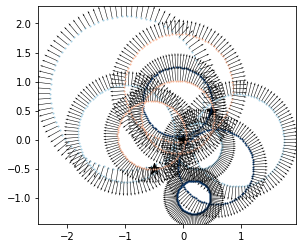

In [13]:
fig = plt.figure(dpi=72)
ax = plt.gca()

max_integ = prob2d_ex2.weights[prob2d_ex3.weights > 0].sum()
min_integ = prob2d_ex2.weights[prob2d_ex3.weights < 0].sum()
cmap = mpl.cm.get_cmap('RdBu')
cnorm = mpl.colors.Normalize(vmin=min_integ, vmax=max_integ)

ax.scatter(prob2d_ex3.locations[:,0], prob2d_ex3.locations[:,1], marker='*', color='black', s=150)
for pnts, srfnrms, center, radius, integ in zip(points, surfacenorms, vols['centers'], vols['radii'], integs):
    ax.scatter(pnts[:,0], pnts[:,1], marker='o', color=cmap(1.0-cnorm(integ.item())), s=1)
    ax.quiver(pnts[:,0], pnts[:,1], srfnrms[:, 0], srfnrms[:, 1], width=0.002)
ax.set_aspect('equal', adjustable='box')

fig

### Defining the Problem

In [14]:
# Set the problem
d = 2
problem = DeltaProblem(weights=np.array([1.0, 1.0, 1.0]),
                       locations=np.array([[ 0.0,  0.0],
                                           [-0.5, -0.5],
                                           [ 0.5,  0.5]]))

volsampler = BallSampler(x_min=np.array([-1.0, -1.0]), x_max=np.array([1.0, 1.0]), r_min=0.1, r_max=1.5)
sphsampler = SphereSampler()

### Function Approximation

In [15]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, inp_width=2, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(inp_width, nn_width).to(device=tch_device, dtype=tch_dtype)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width).to(device=tch_device, dtype=tch_dtype))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1).to(device=tch_device, dtype=tch_dtype)
        
    def forward(self, x):
        activation = nn.SiLU()
        u = activation(self.layer_first(x))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

### First Attempt

This attempt trains a network with the full gradients and a 100 points per sphere. Because of the 100 sampled points per sphere, the estimation bias would be low, which is why it's nicknamed a `lowvar_mse` training. Since the bias is reduced too much, this setting may not be realistic but it will serve as a reference for later comparisons.

In [16]:
n_spheres = 4
n_points = 100
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001

logroot = '01_poisson'

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/01_lowvar_mse_{timestamp}'

In [17]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Seeding all RNGs
volsampler.seed(rng_seed)
sphsampler.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
random.seed(rng_seed)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = ffnn(d, nn_width, nn_hidden)

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres, lib='torch')
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_spheres, n_points, d)
    assert surfacenorms.shape == (n_spheres, n_points, d)
    assert areas.shape == (n_spheres,)
    
    # Making surface integral predictions
    u = model(points)
    assert u.shape == (n_spheres, n_points, 1)
    nabla_x_u, = torch.autograd.grad(u.sum(), [points], grad_outputs=None, retain_graph=True,
                                     create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u.shape == (n_spheres, n_points, d)
    normprods = (nabla_x_u * surfacenorms).sum(dim=-1)
    assert normprods.shape == (n_spheres, n_points)
    mean_normprods = normprods.mean(dim=-1)
    assert mean_normprods.shape == (n_spheres,)
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_spheres,)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_spheres,)
    
    # Computing the loss
    loss = torch.square(pred_surfintegs - ref_volintegs).mean()
    loss.backward()
    opt.step()
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    npvm = (normprods.var(dim=-1)*areas.square()).mean()
    npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
    npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
    npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).item()
    npvm_ema_std = np.sqrt(max(npvm_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    writer.add_scalar('loss/loss', loss, epoch)
    writer.add_scalar('loss/npvm', npvm, epoch)
    stat_history['epoch'].append(epoch)
    stat_history['loss'].append(loss.item())
    stat_history['npvm'].append(npvm.item())
    if epoch % 1000 == 0:
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        points_plt = nn.Parameter(x_plt.unsqueeze(0))
        v_pred = model(points_plt)
        e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                      create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np = v_pred.squeeze().detach().cpu().numpy()
        e_pred_np = e_pred.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization', fig, epoch)
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})

epoch 0, EMA loss = 0.7634 +/- 0.0000, EMA Field-Norm Product Variance = 0.0038 +/- 0.0000
epoch 1000, EMA loss = 0.4338 +/- 0.0000, EMA Field-Norm Product Variance = 0.2284 +/- 0.0134
epoch 2000, EMA loss = 0.2527 +/- 0.0000, EMA Field-Norm Product Variance = 0.4030 +/- 0.0156
epoch 3000, EMA loss = 0.1688 +/- 0.0000, EMA Field-Norm Product Variance = 0.5135 +/- 0.0161
epoch 4000, EMA loss = 0.1351 +/- 0.0022, EMA Field-Norm Product Variance = 0.5775 +/- 0.0165
epoch 5000, EMA loss = 0.1217 +/- 0.0035, EMA Field-Norm Product Variance = 0.6256 +/- 0.0163
epoch 6000, EMA loss = 0.1151 +/- 0.0035, EMA Field-Norm Product Variance = 0.6676 +/- 0.0163
epoch 7000, EMA loss = 0.1105 +/- 0.0036, EMA Field-Norm Product Variance = 0.6632 +/- 0.0162
epoch 8000, EMA loss = 0.1076 +/- 0.0036, EMA Field-Norm Product Variance = 0.6909 +/- 0.0168
epoch 9000, EMA loss = 0.1046 +/- 0.0032, EMA Field-Norm Product Variance = 0.6992 +/- 0.0170
epoch 10000, EMA loss = 0.1030 +/- 0.0032, EMA Field-Norm Produ

epoch 87000, EMA loss = 0.0400 +/- 0.0020, EMA Field-Norm Product Variance = 1.5234 +/- 0.0431
epoch 88000, EMA loss = 0.0382 +/- 0.0018, EMA Field-Norm Product Variance = 1.5442 +/- 0.0423
epoch 89000, EMA loss = 0.0371 +/- 0.0018, EMA Field-Norm Product Variance = 1.5293 +/- 0.0395
epoch 90000, EMA loss = 0.0363 +/- 0.0016, EMA Field-Norm Product Variance = 1.5465 +/- 0.0449
epoch 91000, EMA loss = 0.0398 +/- 0.0019, EMA Field-Norm Product Variance = 1.5570 +/- 0.0426
epoch 92000, EMA loss = 0.0372 +/- 0.0016, EMA Field-Norm Product Variance = 1.5470 +/- 0.0425
epoch 93000, EMA loss = 0.0368 +/- 0.0018, EMA Field-Norm Product Variance = 1.5226 +/- 0.0409
epoch 94000, EMA loss = 0.0383 +/- 0.0018, EMA Field-Norm Product Variance = 1.5361 +/- 0.0429
epoch 95000, EMA loss = 0.0378 +/- 0.0019, EMA Field-Norm Product Variance = 1.5449 +/- 0.0402
epoch 96000, EMA loss = 0.0397 +/- 0.0019, EMA Field-Norm Product Variance = 1.5365 +/- 0.0452
epoch 97000, EMA loss = 0.0390 +/- 0.0018, EMA Fie

epoch 173000, EMA loss = 0.0343 +/- 0.0018, EMA Field-Norm Product Variance = 1.6018 +/- 0.0429
epoch 174000, EMA loss = 0.0340 +/- 0.0016, EMA Field-Norm Product Variance = 1.5918 +/- 0.0440
epoch 175000, EMA loss = 0.0344 +/- 0.0017, EMA Field-Norm Product Variance = 1.5900 +/- 0.0459
epoch 176000, EMA loss = 0.0371 +/- 0.0019, EMA Field-Norm Product Variance = 1.5709 +/- 0.0436
epoch 177000, EMA loss = 0.0351 +/- 0.0016, EMA Field-Norm Product Variance = 1.5758 +/- 0.0439
epoch 178000, EMA loss = 0.0379 +/- 0.0020, EMA Field-Norm Product Variance = 1.5500 +/- 0.0437
epoch 179000, EMA loss = 0.0372 +/- 0.0019, EMA Field-Norm Product Variance = 1.5873 +/- 0.0432
epoch 180000, EMA loss = 0.0356 +/- 0.0017, EMA Field-Norm Product Variance = 1.5646 +/- 0.0435
epoch 181000, EMA loss = 0.0346 +/- 0.0016, EMA Field-Norm Product Variance = 1.6207 +/- 0.0494
epoch 182000, EMA loss = 0.0353 +/- 0.0016, EMA Field-Norm Product Variance = 1.6630 +/- 0.0524
epoch 183000, EMA loss = 0.0355 +/- 0.00

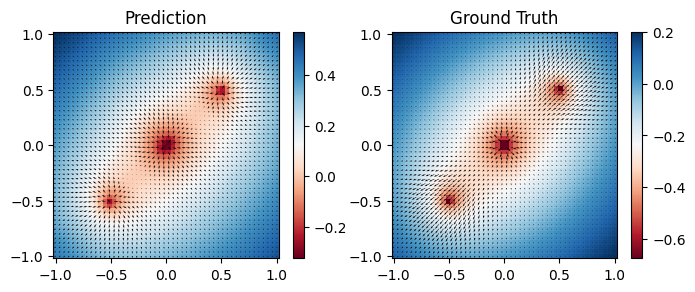

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

points_plt = nn.Parameter(x_plt.unsqueeze(0))
v_pred = model(points_plt)
e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                              create_graph=False, only_inputs=True, allow_unused=False)
v_pred_np = v_pred.squeeze().detach().cpu().numpy()
e_pred_np = e_pred.squeeze().detach().cpu().numpy()

v_true = problem.potential(x_plt_np)
e_true = problem.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true.reshape(*x1_plt_msh_np.shape),
                  e_true.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Ground Truth')
fig

In [19]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")

### Second Attempt
Here, we repeat the first attempt but with only 2 points per sphere. As you can see, the large amount of variance will have a dominating effect on the solution and the loss we find.

In [20]:
n_spheres = 400
n_points = 2
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/02_highvar_mse_{timestamp}'

In [21]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Seeding all RNGs
volsampler.seed(rng_seed)
sphsampler.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
random.seed(rng_seed)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = ffnn(d, nn_width, nn_hidden)

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres, lib='torch')
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_spheres, n_points, d)
    assert surfacenorms.shape == (n_spheres, n_points, d)
    assert areas.shape == (n_spheres,)
    
    # Making surface integral predictions
    u = model(points)
    assert u.shape == (n_spheres, n_points, 1)
    nabla_x_u, = torch.autograd.grad(u.sum(), [points], grad_outputs=None, retain_graph=True,
                                     create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u.shape == (n_spheres, n_points, d)
    normprods = (nabla_x_u * surfacenorms).sum(dim=-1)
    assert normprods.shape == (n_spheres, n_points)
    mean_normprods = normprods.mean(dim=-1)
    assert mean_normprods.shape == (n_spheres,)
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_spheres,)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_spheres,)
    
    # Computing the loss
    loss = torch.square(pred_surfintegs - ref_volintegs).mean()
    loss.backward()
    opt.step()
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    npvm = (normprods.var(dim=-1)*areas.square()).mean()
    npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
    npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
    npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).item()
    npvm_ema_std = np.sqrt(max(npvm_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    writer.add_scalar('loss/loss', loss, epoch)
    writer.add_scalar('loss/npvm', npvm, epoch)
    stat_history['epoch'].append(epoch)
    stat_history['loss'].append(loss.item())
    stat_history['npvm'].append(npvm.item())
    if epoch % 1000 == 0:
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        points_plt = nn.Parameter(x_plt.unsqueeze(0))
        v_pred = model(points_plt)
        e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                      create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np = v_pred.squeeze().detach().cpu().numpy()
        e_pred_np = e_pred.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization', fig, epoch)
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})

epoch 0, EMA loss = 2.9880 +/- 0.0000, EMA Field-Norm Product Variance = 0.0035 +/- 0.0000
epoch 1000, EMA loss = 1.3009 +/- 0.0000, EMA Field-Norm Product Variance = 0.1600 +/- 0.0078
epoch 2000, EMA loss = 0.6549 +/- 0.0000, EMA Field-Norm Product Variance = 0.2229 +/- 0.0058
epoch 3000, EMA loss = 0.4159 +/- 0.0000, EMA Field-Norm Product Variance = 0.2468 +/- 0.0039
epoch 4000, EMA loss = 0.3279 +/- 0.0000, EMA Field-Norm Product Variance = 0.2594 +/- 0.0030
epoch 5000, EMA loss = 0.2950 +/- 0.0000, EMA Field-Norm Product Variance = 0.2628 +/- 0.0020
epoch 6000, EMA loss = 0.2821 +/- 0.0000, EMA Field-Norm Product Variance = 0.2647 +/- 0.0016
epoch 7000, EMA loss = 0.2772 +/- 0.0000, EMA Field-Norm Product Variance = 0.2662 +/- 0.0015
epoch 8000, EMA loss = 0.2733 +/- 0.0000, EMA Field-Norm Product Variance = 0.2663 +/- 0.0013
epoch 9000, EMA loss = 0.2724 +/- 0.0002, EMA Field-Norm Product Variance = 0.2670 +/- 0.0014
epoch 10000, EMA loss = 0.2720 +/- 0.0008, EMA Field-Norm Produ

epoch 87000, EMA loss = 0.2633 +/- 0.0001, EMA Field-Norm Product Variance = 0.2787 +/- 0.0012
epoch 88000, EMA loss = 0.2634 +/- 0.0008, EMA Field-Norm Product Variance = 0.2784 +/- 0.0013
epoch 89000, EMA loss = 0.2637 +/- 0.0008, EMA Field-Norm Product Variance = 0.2803 +/- 0.0015
epoch 90000, EMA loss = 0.2634 +/- 0.0007, EMA Field-Norm Product Variance = 0.2806 +/- 0.0012
epoch 91000, EMA loss = 0.2641 +/- 0.0011, EMA Field-Norm Product Variance = 0.2791 +/- 0.0008
epoch 92000, EMA loss = 0.2642 +/- 0.0007, EMA Field-Norm Product Variance = 0.2792 +/- 0.0014
epoch 93000, EMA loss = 0.2645 +/- 0.0009, EMA Field-Norm Product Variance = 0.2797 +/- 0.0015
epoch 94000, EMA loss = 0.2646 +/- 0.0010, EMA Field-Norm Product Variance = 0.2790 +/- 0.0012
epoch 95000, EMA loss = 0.2646 +/- 0.0009, EMA Field-Norm Product Variance = 0.2775 +/- 0.0010
epoch 96000, EMA loss = 0.2644 +/- 0.0006, EMA Field-Norm Product Variance = 0.2780 +/- 0.0014
epoch 97000, EMA loss = 0.2647 +/- 0.0010, EMA Fie

epoch 173000, EMA loss = 0.2643 +/- 0.0010, EMA Field-Norm Product Variance = 0.2797 +/- 0.0012
epoch 174000, EMA loss = 0.2646 +/- 0.0011, EMA Field-Norm Product Variance = 0.2792 +/- 0.0013
epoch 175000, EMA loss = 0.2634 +/- 0.0000, EMA Field-Norm Product Variance = 0.2785 +/- 0.0010
epoch 176000, EMA loss = 0.2630 +/- 0.0008, EMA Field-Norm Product Variance = 0.2779 +/- 0.0010
epoch 177000, EMA loss = 0.2636 +/- 0.0010, EMA Field-Norm Product Variance = 0.2790 +/- 0.0015
epoch 178000, EMA loss = 0.2647 +/- 0.0012, EMA Field-Norm Product Variance = 0.2795 +/- 0.0016
epoch 179000, EMA loss = 0.2642 +/- 0.0007, EMA Field-Norm Product Variance = 0.2793 +/- 0.0013
epoch 180000, EMA loss = 0.2646 +/- 0.0010, EMA Field-Norm Product Variance = 0.2787 +/- 0.0011
epoch 181000, EMA loss = 0.2644 +/- 0.0010, EMA Field-Norm Product Variance = 0.2792 +/- 0.0014
epoch 182000, EMA loss = 0.2642 +/- 0.0008, EMA Field-Norm Product Variance = 0.2785 +/- 0.0009
epoch 183000, EMA loss = 0.2643 +/- 0.00

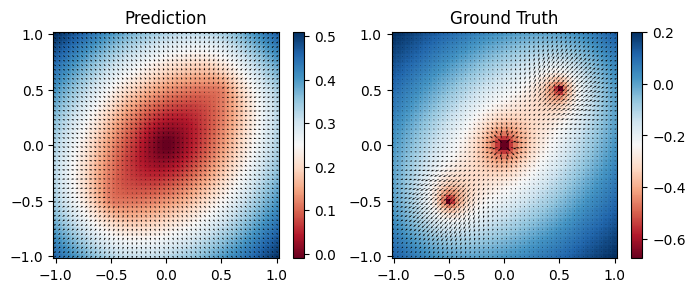

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

points_plt = nn.Parameter(x_plt.unsqueeze(0))
v_pred = model(points_plt)
e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                              create_graph=False, only_inputs=True, allow_unused=False)
v_pred_np = v_pred.squeeze().detach().cpu().numpy()
e_pred_np = e_pred.squeeze().detach().cpu().numpy()

v_true = problem.potential(x_plt_np)
e_true = problem.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true.reshape(*x1_plt_msh_np.shape),
                  e_true.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Ground Truth')
fig

In [23]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")

### Third Attempt
To address the problem with the second attempt, we use bootstrapping. In particular, we implement bootstrapping by creating a separate target netwrok whose parameters are defined as the Polyak exponential moving average of the model parameters. The hyper-parameter `tau=0.999` induces an alomst 1000-iteration horizon for the moving window. Unfortunately, this attempt diverges.

In [24]:
n_spheres = 400
n_points = 2
trg_weight = 0.99
n_epochs = 10_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
tau = 0.999

n_points_mdl = 1
n_points_trg = n_points - n_points_mdl

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/03_highvar_bstrap_{timestamp}'

In [25]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Seeding all RNGs
volsampler.seed(rng_seed)
sphsampler.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
random.seed(rng_seed)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = ffnn(d, nn_width, nn_hidden)
model_target = ffnn(d, nn_width, nn_hidden)
model_target.load_state_dict(model.state_dict())

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
model_trg_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing, tau=tau, 
               n_points_mdl=n_points_mdl, n_points_trg=n_points_trg,
               trg_weight=trg_weight)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres, lib='torch')
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_spheres, n_points, d)
    assert surfacenorms.shape == (n_spheres, n_points, d)
    assert areas.shape == (n_spheres,)
    
    points_mdl = points[:, :n_points_mdl, :]
    assert points_mdl.shape == (n_spheres, n_points_mdl, d)
    points_trg = points[:, n_points_mdl:, :]
    assert points_trg.shape == (n_spheres, n_points_trg, d)
    
    surfacenorms_mdl = surfacenorms[:, :n_points_mdl, :]
    assert surfacenorms_mdl.shape == (n_spheres, n_points_mdl, d)
    surfacenorms_trg = surfacenorms[:, n_points_mdl:, :]
    assert surfacenorms_trg.shape == (n_spheres, n_points_trg, d)
    
    # Making surface integral predictions using the reference model
    u_mdl = model(points_mdl)
    assert u_mdl.shape == (n_spheres, n_points_mdl, 1)
    nabla_x_u_mdl, = torch.autograd.grad(u_mdl.sum(), [points_mdl], grad_outputs=None, retain_graph=True,
                                         create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u_mdl.shape == (n_spheres, n_points_mdl, d)
    normprods_mdl = (nabla_x_u_mdl * surfacenorms_mdl).sum(dim=-1)
    assert normprods_mdl.shape == (n_spheres, n_points_mdl)
    mean_normprods_mdl = normprods_mdl.mean(dim=-1)
    assert mean_normprods_mdl.shape == (n_spheres,)
    
    # Making surface integral predictions using the target model
    u_trg = model_target(points_trg)
    assert u_trg.shape == (n_spheres, n_points_trg, 1)
    nabla_x_u_trg, = torch.autograd.grad(u_trg.sum(), [points_trg], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=False)
    assert nabla_x_u_trg.shape == (n_spheres, n_points_trg, d)
    with torch.no_grad():
        normprods_trg = (nabla_x_u_trg * surfacenorms_trg).sum(dim=-1)
        assert normprods_trg.shape == (n_spheres, n_points_trg)
        mean_normprods_trg = normprods_trg.mean(dim=-1)
        assert mean_normprods_trg.shape == (n_spheres,)
    
    # Linearly combining the reference and target predictions
    mean_normprods = trg_weight * mean_normprods_trg.detach() + (1.0 - trg_weight) * mean_normprods_mdl
    assert mean_normprods.shape == (n_spheres,)
    
    # Considering the surface areas
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_spheres,)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_spheres,)
    
    # Computing the loss
    loss = torch.square(pred_surfintegs - ref_volintegs).mean()
    loss.backward()
    opt.step()
    
    # Updating the target network
    model_sd = model.state_dict()
    model_trg_sd = model_target.state_dict()
    newtrg_sd = dict()
    with torch.no_grad():
        for key, param in model_sd.items():
            param_trg = model_trg_sd[key]
            newtrg_sd[key] = tau * param_trg + (1-tau) * param
    model_target.load_state_dict(newtrg_sd)
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    normprods = torch.cat([normprods_mdl, normprods_trg], dim=-1)
    npvm = (normprods.var(dim=-1)*areas.square()).mean()
    npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
    npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
    npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).item()
    npvm_ema_std = np.sqrt(max(npvm_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    writer.add_scalar('loss/loss', loss, epoch)
    writer.add_scalar('loss/npvm', npvm, epoch)
    stat_history['epoch'].append(epoch)
    stat_history['loss'].append(loss.item())
    stat_history['npvm'].append(npvm.item())
    if epoch % 1000 == 0:
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        points_plt = nn.Parameter(x_plt.unsqueeze(0))
        v_pred = model(points_plt)
        e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                      create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np = v_pred.squeeze().detach().cpu().numpy()
        e_pred_np = e_pred.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/reference', fig, epoch)
        
        v_pred_trg = model_target(points_plt)
        e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                          create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
        e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/target', fig, epoch)
        
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
        model_trg_history[epoch] = deepcopy({k: v.cpu() for k, v in model_target.state_dict().items()})

epoch 0, EMA loss = 2.9743 +/- 0.0000, EMA Field-Norm Product Variance = 0.0035 +/- 0.0000
epoch 1000, EMA loss = 55.5132 +/- 5.5793, EMA Field-Norm Product Variance = 198769.0668 +/- 25407.3371
epoch 2000, EMA loss = 194.6966 +/- 10.6157, EMA Field-Norm Product Variance = 202839.7248 +/- 12594.2938
epoch 3000, EMA loss = 20882.1643 +/- 2588.5928, EMA Field-Norm Product Variance = 9009747.3765 +/- 830907.3828
epoch 4000, EMA loss = 2496864.7215 +/- 223686.6967, EMA Field-Norm Product Variance = 69254574.9848 +/- 4029108.9297
epoch 5000, EMA loss = 93387802.3879 +/- 7613015.0676, EMA Field-Norm Product Variance = 2038217363.2188 +/- 158271803.6064
epoch 6000, EMA loss = 774879073.6248 +/- 43012069.2529, EMA Field-Norm Product Variance = 8217687857.1528 +/- 399289101.5574
epoch 7000, EMA loss = 4555469021.8889 +/- 365953921.4508, EMA Field-Norm Product Variance = 82276383350.0818 +/- 8566469563.3053
epoch 8000, EMA loss = 61447298200.3795 +/- 3265120452.4728, EMA Field-Norm Product Varia

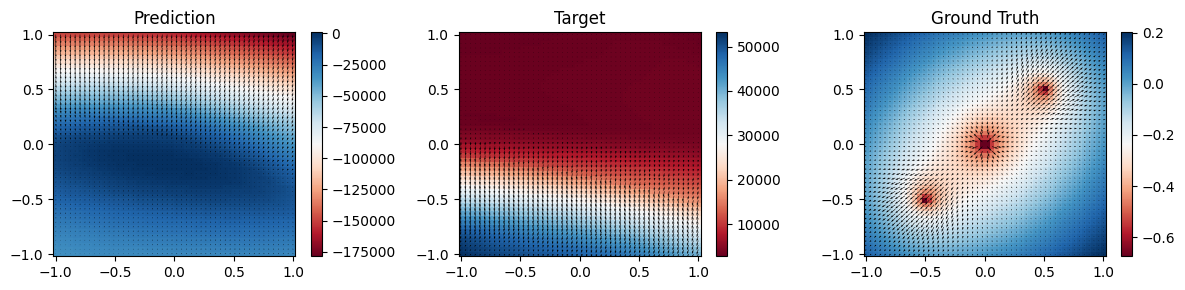

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

points_plt = nn.Parameter(x_plt.unsqueeze(0))
v_pred = model(points_plt)
e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                              create_graph=False, only_inputs=True, allow_unused=False)
v_pred_np = v_pred.squeeze().detach().cpu().numpy()
e_pred_np = e_pred.squeeze().detach().cpu().numpy()

v_pred_trg = model_target(points_plt)
e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                  create_graph=False, only_inputs=True, allow_unused=False)
v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()

v_true = problem.potential(x_plt_np)
e_true = problem.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Target')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true.reshape(*x1_plt_msh_np.shape),
                  e_true.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[2]))
ax.set_title('Ground Truth')
fig.set_tight_layout(True)
fig

In [27]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
torch.save(model_trg_history, f'{storage_dir}/checkpoints_trg.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")

**Theory**: We suspect that this divergence is not due to the bootstrapping itself, but rather the high induced variance in the target values. Let's assume only two points are sampled per sphere: one is passed to the main model, and the other one is passed to the bootstrapped target model. Thus, we want to enforce the following rule during training:

$$\alpha f_{\text{main}}(x_1) + (1-\alpha) \hat{f}_{\text{target}}(x_2) \simeq y$$

This means that

$$f_{\text{main}}(x_1) \simeq y - \frac{1-\alpha}{\alpha} \hat{f}_{\text{target}}(x_2).$$

The variance of the right hand side is therefore 

$$\text{Var}[y - \frac{1-\alpha}{\alpha} \hat{f}_{\text{target}}(x_2)] = \text{Var}[y] + \frac{(1-\alpha)^2}{\alpha^2} \text{Var}_{x_2}[\hat{f}_{\text{target}}(x_2)].$$

We have perfect labels, so $\text{Var}[y]=0$. However, to reduce the effect of the estimation bias, we need to simulate the effect of large $n$ values. Since the weight $\alpha$ resembles the weight $\frac{1}{n}$ in the first attempt, we need to set a small value for $\alpha$ as a result. 

By setting a small $\alpha$, the variance of the RHS will explode due to the $\frac{(1-\alpha)^2}{\alpha^2}$ coefficient. For example, to simulate the effect of $n=100$ samples, we can set $\alpha=0.01$ wich results in a $\frac{(1-\alpha)^2}{\alpha^2}\simeq 10^4$ variance growth. This could explain the divergence due to the high amount of induced target variance in training. 

### Fourth Attempt

Before suggesting any solutions, we need to test this theory. If the above theory is correct, then using a larger $\alpha$ should at least mitigate the divergence problem. Of course, this will negatively impact the solution quality, but we're only interested in the convergence or divergence phenomenon.

Below, we test a value of $\alpha=0.9$ instead. Note that $\alpha$ corresponds to the `trg_weight` hyper-parameter.

In [28]:
n_spheres = 400
n_points = 2
trg_weight = 0.9
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
tau = 0.999

n_points_mdl = 1
n_points_trg = n_points - n_points_mdl

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/04_highvar_bstrap_{timestamp}'

In [29]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Seeding all RNGs
volsampler.seed(rng_seed)
sphsampler.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
random.seed(rng_seed)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = ffnn(d, nn_width, nn_hidden)
model_target = ffnn(d, nn_width, nn_hidden)
model_target.load_state_dict(model.state_dict())

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
model_trg_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing, tau=tau, 
               n_points_mdl=n_points_mdl, n_points_trg=n_points_trg,
               trg_weight=trg_weight)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres, lib='torch')
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_spheres, n_points, d)
    assert surfacenorms.shape == (n_spheres, n_points, d)
    assert areas.shape == (n_spheres,)
    
    points_mdl = points[:, :n_points_mdl, :]
    assert points_mdl.shape == (n_spheres, n_points_mdl, d)
    points_trg = points[:, n_points_mdl:, :]
    assert points_trg.shape == (n_spheres, n_points_trg, d)
    
    surfacenorms_mdl = surfacenorms[:, :n_points_mdl, :]
    assert surfacenorms_mdl.shape == (n_spheres, n_points_mdl, d)
    surfacenorms_trg = surfacenorms[:, n_points_mdl:, :]
    assert surfacenorms_trg.shape == (n_spheres, n_points_trg, d)
    
    # Making surface integral predictions using the reference model
    u_mdl = model(points_mdl)
    assert u_mdl.shape == (n_spheres, n_points_mdl, 1)
    nabla_x_u_mdl, = torch.autograd.grad(u_mdl.sum(), [points_mdl], grad_outputs=None, retain_graph=True,
                                         create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u_mdl.shape == (n_spheres, n_points_mdl, d)
    normprods_mdl = (nabla_x_u_mdl * surfacenorms_mdl).sum(dim=-1)
    assert normprods_mdl.shape == (n_spheres, n_points_mdl)
    mean_normprods_mdl = normprods_mdl.mean(dim=-1)
    assert mean_normprods_mdl.shape == (n_spheres,)
    
    # Making surface integral predictions using the target model
    u_trg = model_target(points_trg)
    assert u_trg.shape == (n_spheres, n_points_trg, 1)
    nabla_x_u_trg, = torch.autograd.grad(u_trg.sum(), [points_trg], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=False)
    assert nabla_x_u_trg.shape == (n_spheres, n_points_trg, d)
    with torch.no_grad():
        normprods_trg = (nabla_x_u_trg * surfacenorms_trg).sum(dim=-1)
        assert normprods_trg.shape == (n_spheres, n_points_trg)
        mean_normprods_trg = normprods_trg.mean(dim=-1)
        assert mean_normprods_trg.shape == (n_spheres,)
    
    # Linearly combining the reference and target predictions
    mean_normprods = trg_weight * mean_normprods_trg.detach() + (1.0 - trg_weight) * mean_normprods_mdl
    assert mean_normprods.shape == (n_spheres,)
    
    # Considering the surface areas
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_spheres,)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_spheres,)
    
    # Computing the loss
    loss = torch.square(pred_surfintegs - ref_volintegs).mean()
    loss.backward()
    opt.step()
    
    # Updating the target network
    model_sd = model.state_dict()
    model_trg_sd = model_target.state_dict()
    newtrg_sd = dict()
    with torch.no_grad():
        for key, param in model_sd.items():
            param_trg = model_trg_sd[key]
            newtrg_sd[key] = tau * param_trg + (1-tau) * param
    model_target.load_state_dict(newtrg_sd)
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    normprods = torch.cat([normprods_mdl, normprods_trg], dim=-1)
    npvm = (normprods.var(dim=-1)*areas.square()).mean()
    npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
    npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
    npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).item()
    npvm_ema_std = np.sqrt(max(npvm_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    writer.add_scalar('loss/loss', loss, epoch)
    writer.add_scalar('loss/npvm', npvm, epoch)
    stat_history['epoch'].append(epoch)
    stat_history['loss'].append(loss.item())
    stat_history['npvm'].append(npvm.item())
    if epoch % 1000 == 0:
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        points_plt = nn.Parameter(x_plt.unsqueeze(0))
        v_pred = model(points_plt)
        e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                      create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np = v_pred.squeeze().detach().cpu().numpy()
        e_pred_np = e_pred.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/reference', fig, epoch)
        
        v_pred_trg = model_target(points_plt)
        e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                          create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
        e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/target', fig, epoch)
        
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
        model_trg_history[epoch] = deepcopy({k: v.cpu() for k, v in model_target.state_dict().items()})

epoch 0, EMA loss = 2.9765 +/- 0.0000, EMA Field-Norm Product Variance = 0.7500 +/- 0.0000
epoch 1000, EMA loss = 1.5496 +/- 0.0000, EMA Field-Norm Product Variance = 0.7917 +/- 0.0077
epoch 2000, EMA loss = 1.3060 +/- 0.0000, EMA Field-Norm Product Variance = 0.8087 +/- 0.0064
epoch 3000, EMA loss = 0.8075 +/- 0.0000, EMA Field-Norm Product Variance = 0.8122 +/- 0.0046
epoch 4000, EMA loss = 0.6003 +/- 0.0000, EMA Field-Norm Product Variance = 0.8129 +/- 0.0039
epoch 5000, EMA loss = 0.5195 +/- 0.0000, EMA Field-Norm Product Variance = 0.8154 +/- 0.0046
epoch 6000, EMA loss = 0.4847 +/- 0.0000, EMA Field-Norm Product Variance = 0.8161 +/- 0.0033
epoch 7000, EMA loss = 0.4748 +/- 0.0000, EMA Field-Norm Product Variance = 0.8171 +/- 0.0035
epoch 8000, EMA loss = 0.4730 +/- 0.0006, EMA Field-Norm Product Variance = 0.8197 +/- 0.0041
epoch 9000, EMA loss = 0.4724 +/- 0.0012, EMA Field-Norm Product Variance = 0.8176 +/- 0.0033
epoch 10000, EMA loss = 0.4712 +/- 0.0014, EMA Field-Norm Produ

epoch 87000, EMA loss = 0.5392 +/- 0.0026, EMA Field-Norm Product Variance = 0.8122 +/- 0.0027
epoch 88000, EMA loss = 0.5383 +/- 0.0025, EMA Field-Norm Product Variance = 0.8176 +/- 0.0046
epoch 89000, EMA loss = 0.5360 +/- 0.0020, EMA Field-Norm Product Variance = 0.8149 +/- 0.0027
epoch 90000, EMA loss = 0.5356 +/- 0.0024, EMA Field-Norm Product Variance = 0.8159 +/- 0.0039
epoch 91000, EMA loss = 0.5390 +/- 0.0035, EMA Field-Norm Product Variance = 0.8130 +/- 0.0028
epoch 92000, EMA loss = 0.5387 +/- 0.0022, EMA Field-Norm Product Variance = 0.8142 +/- 0.0035
epoch 93000, EMA loss = 0.5411 +/- 0.0030, EMA Field-Norm Product Variance = 0.8136 +/- 0.0034
epoch 94000, EMA loss = 0.5438 +/- 0.0029, EMA Field-Norm Product Variance = 0.8162 +/- 0.0037
epoch 95000, EMA loss = 0.5358 +/- 0.0000, EMA Field-Norm Product Variance = 0.8172 +/- 0.0038
epoch 96000, EMA loss = 0.5328 +/- 0.0022, EMA Field-Norm Product Variance = 0.8156 +/- 0.0025
epoch 97000, EMA loss = 0.5361 +/- 0.0031, EMA Fie

epoch 173000, EMA loss = 0.5491 +/- 0.0029, EMA Field-Norm Product Variance = 0.8156 +/- 0.0033
epoch 174000, EMA loss = 0.5481 +/- 0.0030, EMA Field-Norm Product Variance = 0.8160 +/- 0.0034
epoch 175000, EMA loss = 0.5481 +/- 0.0024, EMA Field-Norm Product Variance = 0.8181 +/- 0.0045
epoch 176000, EMA loss = 0.5426 +/- 0.0016, EMA Field-Norm Product Variance = 0.8150 +/- 0.0032
epoch 177000, EMA loss = 0.5410 +/- 0.0027, EMA Field-Norm Product Variance = 0.8170 +/- 0.0037
epoch 178000, EMA loss = 0.5455 +/- 0.0035, EMA Field-Norm Product Variance = 0.8179 +/- 0.0040
epoch 179000, EMA loss = 0.5439 +/- 0.0027, EMA Field-Norm Product Variance = 0.8181 +/- 0.0036
epoch 180000, EMA loss = 0.5441 +/- 0.0023, EMA Field-Norm Product Variance = 0.8172 +/- 0.0035
epoch 181000, EMA loss = 0.5446 +/- 0.0029, EMA Field-Norm Product Variance = 0.8146 +/- 0.0030
epoch 182000, EMA loss = 0.5399 +/- 0.0010, EMA Field-Norm Product Variance = 0.8154 +/- 0.0034
epoch 183000, EMA loss = 0.5405 +/- 0.00

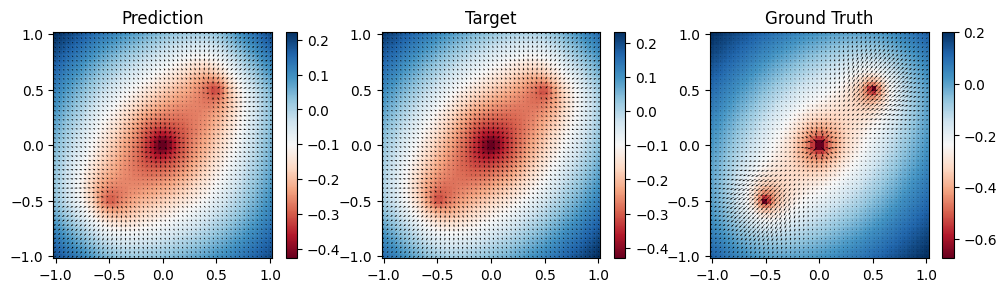

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

points_plt = nn.Parameter(x_plt.unsqueeze(0))
v_pred = model(points_plt)
e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                              create_graph=False, only_inputs=True, allow_unused=False)
v_pred_np = v_pred.squeeze().detach().cpu().numpy()
e_pred_np = e_pred.squeeze().detach().cpu().numpy()

v_pred_trg = model_target(points_plt)
e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                  create_graph=False, only_inputs=True, allow_unused=False)
v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()

v_true = problem.potential(x_plt_np)
e_true = problem.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Target')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true.reshape(*x1_plt_msh_np.shape),
                  e_true.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[2]))
ax.set_title('Ground Truth')
fig

In [31]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
torch.save(model_trg_history, f'{storage_dir}/checkpoints_trg.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")

As you can see the solution is overly smooth, but the training is not diverging anymore. This confirms our theory.

### Fifth Attempt

To mitigate the exploding variance issue, we propose adding a regularization loss term. In particular, although the target for each point has high variance, we know that the main and the target model should not be very different from each other during training. That's why we add a regularization MSE loss term between the main and the target model. See the `loss_trgreg` definition regarding this.

In [32]:
n_spheres = 400
n_points = 2
trg_weight = 0.99
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
tau = 0.9999

n_points_mdl = 1
n_points_trg = n_points - n_points_mdl

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/05_highvar_bstrap_{timestamp}'

In [33]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Seeding all RNGs
volsampler.seed(rng_seed)
sphsampler.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
random.seed(rng_seed)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = ffnn(d, nn_width, nn_hidden)
model_target = ffnn(d, nn_width, nn_hidden)
model_target.load_state_dict(model.state_dict())

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
model_trg_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing, tau=tau, 
               n_points_mdl=n_points_mdl, n_points_trg=n_points_trg,
               trg_weight=trg_weight)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres, lib='torch')
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_spheres, n_points, d)
    assert surfacenorms.shape == (n_spheres, n_points, d)
    assert areas.shape == (n_spheres,)
    
    points_mdl = points[:, :n_points_mdl, :]
    assert points_mdl.shape == (n_spheres, n_points_mdl, d)
    points_trg = points[:, n_points_mdl:, :]
    assert points_trg.shape == (n_spheres, n_points_trg, d)
    
    surfacenorms_mdl = surfacenorms[:, :n_points_mdl, :]
    assert surfacenorms_mdl.shape == (n_spheres, n_points_mdl, d)
    surfacenorms_trg = surfacenorms[:, n_points_mdl:, :]
    assert surfacenorms_trg.shape == (n_spheres, n_points_trg, d)
    
    # Making surface integral predictions using the reference model
    u_mdl = model(points_mdl)
    assert u_mdl.shape == (n_spheres, n_points_mdl, 1)
    nabla_x_u_mdl, = torch.autograd.grad(u_mdl.sum(), [points_mdl], grad_outputs=None, retain_graph=True,
                                         create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u_mdl.shape == (n_spheres, n_points_mdl, d)
    normprods_mdl = (nabla_x_u_mdl * surfacenorms_mdl).sum(dim=-1)
    assert normprods_mdl.shape == (n_spheres, n_points_mdl)
    mean_normprods_mdl = normprods_mdl.mean(dim=-1)
    assert mean_normprods_mdl.shape == (n_spheres,)
    
    # Making surface integral predictions using the target model
    u_trg = model_target(points_trg)
    assert u_trg.shape == (n_spheres, n_points_trg, 1)
    nabla_x_u_trg, = torch.autograd.grad(u_trg.sum(), [points_trg], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=False)
    assert nabla_x_u_trg.shape == (n_spheres, n_points_trg, d)
    with torch.no_grad():
        normprods_trg = (nabla_x_u_trg * surfacenorms_trg).sum(dim=-1)
        assert normprods_trg.shape == (n_spheres, n_points_trg)
        mean_normprods_trg = normprods_trg.mean(dim=-1)
        assert mean_normprods_trg.shape == (n_spheres,)
    
    # Linearly combining the reference and target predictions
    mean_normprods = trg_weight * mean_normprods_trg.detach() + (1.0 - trg_weight) * mean_normprods_mdl
    assert mean_normprods.shape == (n_spheres,)
    
    # Considering the surface areas
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_spheres,)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_spheres,)
    
    # Computing the loss
    loss = torch.square(pred_surfintegs - ref_volintegs).mean()
    
    u_mdl_prime = model_target(points_mdl)
    loss_trgreg = torch.square(u_mdl - u_mdl_prime).mean()
    loss = loss + loss_trgreg
    
    loss.backward()
    opt.step()
    
    # Updating the target network
    model_sd = model.state_dict()
    model_trg_sd = model_target.state_dict()
    newtrg_sd = dict()
    with torch.no_grad():
        for key, param in model_sd.items():
            param_trg = model_trg_sd[key]
            newtrg_sd[key] = tau * param_trg + (1-tau) * param
    model_target.load_state_dict(newtrg_sd)
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    normprods = torch.cat([normprods_mdl, normprods_trg], dim=-1)
    npvm = (normprods.var(dim=-1)*areas.square()).mean()
    npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
    npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
    npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).item()
    npvm_ema_std = np.sqrt(max(npvm_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    writer.add_scalar('loss/loss', loss, epoch)
    writer.add_scalar('loss/npvm', npvm, epoch)
    writer.add_scalar('loss/trgreg', loss_trgreg, epoch)
    stat_history['epoch'].append(epoch)
    stat_history['loss'].append(loss.item())
    stat_history['npvm'].append(npvm.item())
    
    if epoch % 1000 == 0:
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        points_plt = nn.Parameter(x_plt.unsqueeze(0))
        v_pred = model(points_plt)
        e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                      create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np = v_pred.squeeze().detach().cpu().numpy()
        e_pred_np = e_pred.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/reference', fig, epoch)
        
        v_pred_trg = model_target(points_plt)
        e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                          create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
        e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/target', fig, epoch)
        
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
        model_trg_history[epoch] = deepcopy({k: v.cpu() for k, v in model_target.state_dict().items()})

epoch 0, EMA loss = 2.9743 +/- 0.0000, EMA Field-Norm Product Variance = 0.7500 +/- 0.0000
epoch 1000, EMA loss = 2.8272 +/- 0.0000, EMA Field-Norm Product Variance = 0.7917 +/- 0.0077
epoch 2000, EMA loss = 2.6103 +/- 0.0000, EMA Field-Norm Product Variance = 0.8087 +/- 0.0064
epoch 3000, EMA loss = 2.3303 +/- 0.0000, EMA Field-Norm Product Variance = 0.8122 +/- 0.0046
epoch 4000, EMA loss = 2.0297 +/- 0.0000, EMA Field-Norm Product Variance = 0.8129 +/- 0.0039
epoch 5000, EMA loss = 1.7519 +/- 0.0000, EMA Field-Norm Product Variance = 0.8154 +/- 0.0046
epoch 6000, EMA loss = 1.5286 +/- 0.0000, EMA Field-Norm Product Variance = 0.8161 +/- 0.0033
epoch 7000, EMA loss = 1.3801 +/- 0.0000, EMA Field-Norm Product Variance = 0.8171 +/- 0.0035
epoch 8000, EMA loss = 1.2797 +/- 0.0000, EMA Field-Norm Product Variance = 0.8197 +/- 0.0041
epoch 9000, EMA loss = 1.2135 +/- 0.0000, EMA Field-Norm Product Variance = 0.8176 +/- 0.0033
epoch 10000, EMA loss = 1.1647 +/- 0.0000, EMA Field-Norm Produ

epoch 87000, EMA loss = 1.0838 +/- 0.0110, EMA Field-Norm Product Variance = 0.8122 +/- 0.0027
epoch 88000, EMA loss = 1.0870 +/- 0.0107, EMA Field-Norm Product Variance = 0.8176 +/- 0.0046
epoch 89000, EMA loss = 1.0820 +/- 0.0096, EMA Field-Norm Product Variance = 0.8149 +/- 0.0027
epoch 90000, EMA loss = 1.0881 +/- 0.0102, EMA Field-Norm Product Variance = 0.8159 +/- 0.0039
epoch 91000, EMA loss = 1.0895 +/- 0.0104, EMA Field-Norm Product Variance = 0.8130 +/- 0.0028
epoch 92000, EMA loss = 1.0995 +/- 0.0107, EMA Field-Norm Product Variance = 0.8142 +/- 0.0035
epoch 93000, EMA loss = 1.0919 +/- 0.0089, EMA Field-Norm Product Variance = 0.8136 +/- 0.0034
epoch 94000, EMA loss = 1.0990 +/- 0.0107, EMA Field-Norm Product Variance = 0.8162 +/- 0.0037
epoch 95000, EMA loss = 1.0960 +/- 0.0104, EMA Field-Norm Product Variance = 0.8172 +/- 0.0038
epoch 96000, EMA loss = 1.0858 +/- 0.0089, EMA Field-Norm Product Variance = 0.8156 +/- 0.0025
epoch 97000, EMA loss = 1.0875 +/- 0.0094, EMA Fie

epoch 174000, EMA loss = 1.1464 +/- 0.0118, EMA Field-Norm Product Variance = 0.8160 +/- 0.0034
epoch 175000, EMA loss = 1.1524 +/- 0.0118, EMA Field-Norm Product Variance = 0.8181 +/- 0.0045
epoch 176000, EMA loss = 1.1510 +/- 0.0118, EMA Field-Norm Product Variance = 0.8150 +/- 0.0032
epoch 177000, EMA loss = 1.1384 +/- 0.0099, EMA Field-Norm Product Variance = 0.8170 +/- 0.0037
epoch 178000, EMA loss = 1.1504 +/- 0.0121, EMA Field-Norm Product Variance = 0.8179 +/- 0.0040
epoch 179000, EMA loss = 1.1436 +/- 0.0113, EMA Field-Norm Product Variance = 0.8181 +/- 0.0036
epoch 180000, EMA loss = 1.1479 +/- 0.0100, EMA Field-Norm Product Variance = 0.8172 +/- 0.0035
epoch 181000, EMA loss = 1.1441 +/- 0.0110, EMA Field-Norm Product Variance = 0.8146 +/- 0.0030
epoch 182000, EMA loss = 1.1372 +/- 0.0096, EMA Field-Norm Product Variance = 0.8154 +/- 0.0034
epoch 183000, EMA loss = 1.1539 +/- 0.0123, EMA Field-Norm Product Variance = 0.8156 +/- 0.0035
epoch 184000, EMA loss = 1.1461 +/- 0.01

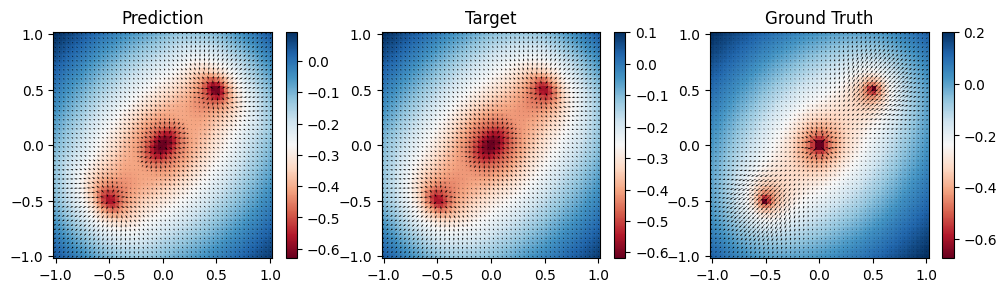

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

points_plt = nn.Parameter(x_plt.unsqueeze(0))
v_pred = model(points_plt)
e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                              create_graph=False, only_inputs=True, allow_unused=False)
v_pred_np = v_pred.squeeze().detach().cpu().numpy()
e_pred_np = e_pred.squeeze().detach().cpu().numpy()

v_pred_trg = model_target(points_plt)
e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                  create_graph=False, only_inputs=True, allow_unused=False)
v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()

v_true = problem.potential(x_plt_np)
e_true = problem.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Target')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true.reshape(*x1_plt_msh_np.shape),
                  e_true.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[2]))
ax.set_title('Ground Truth')
fig

In [35]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
torch.save(model_trg_history, f'{storage_dir}/checkpoints_trg.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")

### Sixth Attempt

Since the last attempt worked well, we'll just retrain the same setting, except with a faster following of the bootstrap model. That is we reduce the bootstrapping window from 10,000 iterations (`tau=0.9999`) to 1000 iterations (`tau=0.999`). This is only done to make the training faster.

In [36]:
n_spheres = 400
n_points = 2
trg_weight = 0.99
n_epochs = 200_000
do_detspacing = False
rng_seed = 12345
lr = 0.001
tau = 0.999

n_points_mdl = 1
n_points_trg = n_points - n_points_mdl

timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{logroot}/06_highvar_bstrap_{timestamp}'

In [37]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Seeding all RNGs
volsampler.seed(rng_seed)
sphsampler.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)
random.seed(rng_seed)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = ffnn(d, nn_width, nn_hidden)
model_target = ffnn(d, nn_width, nn_hidden)
model_target.load_state_dict(model.state_dict())

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
model_trg_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing, tau=tau, 
               n_points_mdl=n_points_mdl, n_points_trg=n_points_trg,
               trg_weight=trg_weight)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres, lib='torch')
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_spheres, n_points, d)
    assert surfacenorms.shape == (n_spheres, n_points, d)
    assert areas.shape == (n_spheres,)
    
    points_mdl = points[:, :n_points_mdl, :]
    assert points_mdl.shape == (n_spheres, n_points_mdl, d)
    points_trg = points[:, n_points_mdl:, :]
    assert points_trg.shape == (n_spheres, n_points_trg, d)
    
    surfacenorms_mdl = surfacenorms[:, :n_points_mdl, :]
    assert surfacenorms_mdl.shape == (n_spheres, n_points_mdl, d)
    surfacenorms_trg = surfacenorms[:, n_points_mdl:, :]
    assert surfacenorms_trg.shape == (n_spheres, n_points_trg, d)
    
    # Making surface integral predictions using the reference model
    u_mdl = model(points_mdl)
    assert u_mdl.shape == (n_spheres, n_points_mdl, 1)
    nabla_x_u_mdl, = torch.autograd.grad(u_mdl.sum(), [points_mdl], grad_outputs=None, retain_graph=True,
                                         create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u_mdl.shape == (n_spheres, n_points_mdl, d)
    normprods_mdl = (nabla_x_u_mdl * surfacenorms_mdl).sum(dim=-1)
    assert normprods_mdl.shape == (n_spheres, n_points_mdl)
    mean_normprods_mdl = normprods_mdl.mean(dim=-1)
    assert mean_normprods_mdl.shape == (n_spheres,)
    
    # Making surface integral predictions using the target model
    u_trg = model_target(points_trg)
    assert u_trg.shape == (n_spheres, n_points_trg, 1)
    nabla_x_u_trg, = torch.autograd.grad(u_trg.sum(), [points_trg], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=False)
    assert nabla_x_u_trg.shape == (n_spheres, n_points_trg, d)
    with torch.no_grad():
        normprods_trg = (nabla_x_u_trg * surfacenorms_trg).sum(dim=-1)
        assert normprods_trg.shape == (n_spheres, n_points_trg)
        mean_normprods_trg = normprods_trg.mean(dim=-1)
        assert mean_normprods_trg.shape == (n_spheres,)
    
    # Linearly combining the reference and target predictions
    mean_normprods = trg_weight * mean_normprods_trg.detach() + (1.0 - trg_weight) * mean_normprods_mdl
    assert mean_normprods.shape == (n_spheres,)
    
    # Considering the surface areas
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_spheres,)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_spheres,)
    
    # Computing the loss
    loss = torch.square(pred_surfintegs - ref_volintegs).mean()
    
    u_mdl_prime = model_target(points_mdl)
    loss_trgreg = torch.square(u_mdl - u_mdl_prime).mean()
    loss = loss + loss_trgreg
    
    loss.backward()
    opt.step()
    
    # Updating the target network
    model_sd = model.state_dict()
    model_trg_sd = model_target.state_dict()
    newtrg_sd = dict()
    with torch.no_grad():
        for key, param in model_sd.items():
            param_trg = model_trg_sd[key]
            newtrg_sd[key] = tau * param_trg + (1-tau) * param
    model_target.load_state_dict(newtrg_sd)
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
    loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
    loss_popvar = (loss_ema_sq - (loss_ema**2)).item()
    loss_ema_std = np.sqrt(max(loss_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    normprods = torch.cat([normprods_mdl, normprods_trg], dim=-1)
    npvm = (normprods.var(dim=-1)*areas.square()).mean()
    npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
    npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
    npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).item()
    npvm_ema_std = np.sqrt(max(npvm_popvar, 0)) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
    
    writer.add_scalar('loss/loss', loss, epoch)
    writer.add_scalar('loss/npvm', npvm, epoch)
    writer.add_scalar('loss/trgreg', loss_trgreg, epoch)
    stat_history['epoch'].append(epoch)
    stat_history['loss'].append(loss.item())
    stat_history['npvm'].append(npvm.item())
    
    if epoch % 1000 == 0:
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema:.4f} +/- {2*loss_ema_std:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema:.4f} +/- {2*npvm_ema_std:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        points_plt = nn.Parameter(x_plt.unsqueeze(0))
        v_pred = model(points_plt)
        e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                      create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np = v_pred.squeeze().detach().cpu().numpy()
        e_pred_np = e_pred.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/reference', fig, epoch)
        
        v_pred_trg = model_target(points_plt)
        e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                          create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
        e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                          e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/target', fig, epoch)
        
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
        model_trg_history[epoch] = deepcopy({k: v.cpu() for k, v in model_target.state_dict().items()})

epoch 0, EMA loss = 2.9743 +/- 0.0000, EMA Field-Norm Product Variance = 0.7500 +/- 0.0000
epoch 1000, EMA loss = 2.2486 +/- 0.0000, EMA Field-Norm Product Variance = 0.7917 +/- 0.0077
epoch 2000, EMA loss = 1.5156 +/- 0.0000, EMA Field-Norm Product Variance = 0.8087 +/- 0.0064
epoch 3000, EMA loss = 1.0623 +/- 0.0000, EMA Field-Norm Product Variance = 0.8122 +/- 0.0046
epoch 4000, EMA loss = 0.7880 +/- 0.0000, EMA Field-Norm Product Variance = 0.8129 +/- 0.0039
epoch 5000, EMA loss = 0.6310 +/- 0.0000, EMA Field-Norm Product Variance = 0.8154 +/- 0.0046
epoch 6000, EMA loss = 0.5421 +/- 0.0000, EMA Field-Norm Product Variance = 0.8161 +/- 0.0033
epoch 7000, EMA loss = 0.5135 +/- 0.0000, EMA Field-Norm Product Variance = 0.8171 +/- 0.0035
epoch 8000, EMA loss = 0.5302 +/- 0.0046, EMA Field-Norm Product Variance = 0.8197 +/- 0.0041
epoch 9000, EMA loss = 0.5714 +/- 0.0071, EMA Field-Norm Product Variance = 0.8176 +/- 0.0033
epoch 10000, EMA loss = 0.6146 +/- 0.0077, EMA Field-Norm Produ

epoch 87000, EMA loss = 1.3304 +/- 0.0152, EMA Field-Norm Product Variance = 0.8122 +/- 0.0027
epoch 88000, EMA loss = 1.3731 +/- 0.0197, EMA Field-Norm Product Variance = 0.8176 +/- 0.0046
epoch 89000, EMA loss = 1.3372 +/- 0.0118, EMA Field-Norm Product Variance = 0.8149 +/- 0.0027
epoch 90000, EMA loss = 1.2850 +/- 0.0069, EMA Field-Norm Product Variance = 0.8159 +/- 0.0039
epoch 91000, EMA loss = 1.3245 +/- 0.0179, EMA Field-Norm Product Variance = 0.8130 +/- 0.0028
epoch 92000, EMA loss = 1.3549 +/- 0.0171, EMA Field-Norm Product Variance = 0.8142 +/- 0.0035
epoch 93000, EMA loss = 1.3683 +/- 0.0177, EMA Field-Norm Product Variance = 0.8136 +/- 0.0034
epoch 94000, EMA loss = 1.3885 +/- 0.0182, EMA Field-Norm Product Variance = 0.8162 +/- 0.0037
epoch 95000, EMA loss = 1.3350 +/- 0.0113, EMA Field-Norm Product Variance = 0.8172 +/- 0.0038
epoch 96000, EMA loss = 1.3421 +/- 0.0179, EMA Field-Norm Product Variance = 0.8156 +/- 0.0025
epoch 97000, EMA loss = 1.3540 +/- 0.0175, EMA Fie

epoch 173000, EMA loss = 1.4097 +/- 0.0186, EMA Field-Norm Product Variance = 0.8156 +/- 0.0033
epoch 174000, EMA loss = 1.4217 +/- 0.0212, EMA Field-Norm Product Variance = 0.8160 +/- 0.0034
epoch 175000, EMA loss = 1.4508 +/- 0.0222, EMA Field-Norm Product Variance = 0.8181 +/- 0.0045
epoch 176000, EMA loss = 1.4114 +/- 0.0157, EMA Field-Norm Product Variance = 0.8150 +/- 0.0032
epoch 177000, EMA loss = 1.3774 +/- 0.0153, EMA Field-Norm Product Variance = 0.8170 +/- 0.0037
epoch 178000, EMA loss = 1.3950 +/- 0.0184, EMA Field-Norm Product Variance = 0.8179 +/- 0.0040
epoch 179000, EMA loss = 1.3853 +/- 0.0182, EMA Field-Norm Product Variance = 0.8181 +/- 0.0036
epoch 180000, EMA loss = 1.3883 +/- 0.0157, EMA Field-Norm Product Variance = 0.8172 +/- 0.0035
epoch 181000, EMA loss = 1.3867 +/- 0.0164, EMA Field-Norm Product Variance = 0.8146 +/- 0.0030
epoch 182000, EMA loss = 1.3818 +/- 0.0149, EMA Field-Norm Product Variance = 0.8154 +/- 0.0034
epoch 183000, EMA loss = 1.4101 +/- 0.02

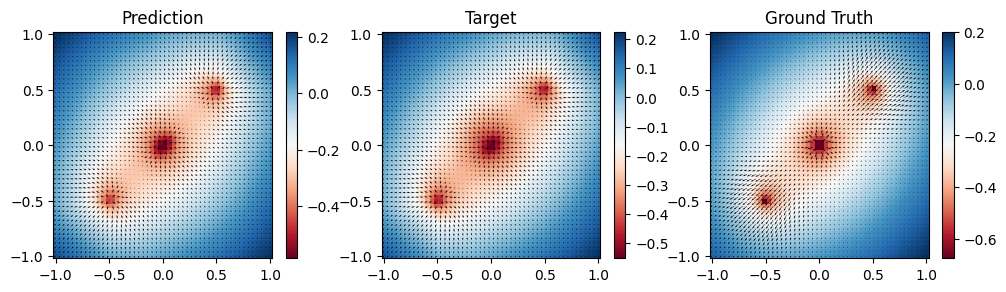

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

points_plt = nn.Parameter(x_plt.unsqueeze(0))
v_pred = model(points_plt)
e_pred, = torch.autograd.grad(v_pred.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                              create_graph=False, only_inputs=True, allow_unused=False)
v_pred_np = v_pred.squeeze().detach().cpu().numpy()
e_pred_np = e_pred.squeeze().detach().cpu().numpy()

v_pred_trg = model_target(points_plt)
e_pred_trg, = torch.autograd.grad(v_pred_trg.sum(), [points_plt], grad_outputs=None, retain_graph=False,
                                  create_graph=False, only_inputs=True, allow_unused=False)
v_pred_trg_np = v_pred_trg.squeeze().detach().cpu().numpy()
e_pred_trg_np = e_pred_trg.squeeze().detach().cpu().numpy()

v_true = problem.potential(x_plt_np)
e_true = problem.field(x_plt_np)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_trg_np.reshape(*x1_plt_msh_np.shape),
                  e_pred_trg_np.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Target')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true.reshape(*x1_plt_msh_np.shape),
                  e_true.reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[2]))
ax.set_title('Ground Truth')
fig

In [39]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
torch.save(model_trg_history, f'{storage_dir}/checkpoints_trg.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")

### Can we compute the analytical solution's surface integration variance?

In [40]:
n_spheres = 1000
n_points = 10000

volsampler.seed(12345)
sphsampler.seed(12345)

# Sampling the volumes
volsamps = volsampler(n=n_spheres, lib='torch')

# Sampling the points from the spheres
sphsamps = sphsampler(volsamps, n_points, do_detspacing=True)
points = nn.Parameter(sphsamps['points'])
surfacenorms = sphsamps['normals']
areas = sphsamps['areas']
assert points.shape == (n_spheres, n_points, d)
assert surfacenorms.shape == (n_spheres, n_points, d)
assert areas.shape == (n_spheres,)

points_e_true = problem.field(points.reshape(n_spheres * n_points, d)).reshape(n_spheres, n_points, d)

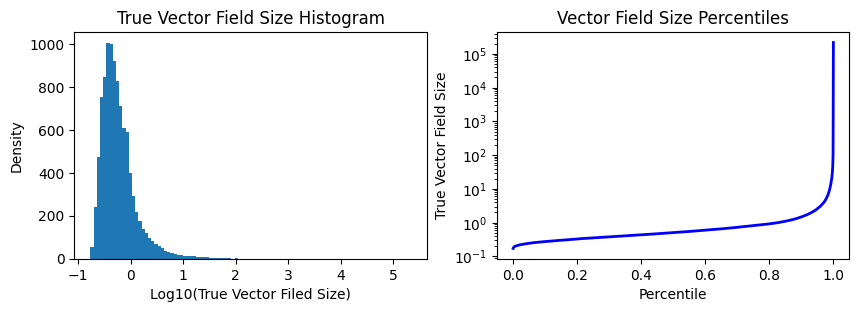

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=100)

field_sizes = points_e_true.norm(dim=-1).reshape(-1)
assert field_sizes.shape == (n_spheres*n_points,)
q = torch.linspace(0, 1, 1001, dtype=tch_dtype, device=tch_device)
quants = field_sizes.quantile(q)

keepidxs = torch.linspace(0, n_spheres*n_points-1, 10000)
keepidxs = keepidxs.round().to(dtype=torch.long, device=tch_device)
field_sizes_sorted = torch.sort(field_sizes).values
field_sizes_ss = field_sizes_sorted.index_select(dim=0, index=keepidxs)

ax = axes[0]
ax.hist(field_sizes_ss.log10().detach().cpu().numpy(), bins=100)
ax.set_title('True Vector Field Size Histogram')
ax.set_ylabel('Density')
ax.set_xlabel('Log10(True Vector Filed Size)')

ax = axes[1]
ax.plot(q.detach().cpu().numpy(), quants.detach().cpu().numpy(), color='blue', lw=2)
ax.set_title('Vector Field Size Percentiles')
ax.set_xlabel('Percentile')
ax.set_ylabel('True Vector Field Size')
ax.set_yscale('log')

fig

As you can see above, the singularities in the true vector fields show up with a non-negligible probability, and push the surface normal product variance to infinity.